# Lab 3: Gaussian process regression

### Machine Learning 1, September 2015

* The lab exercises should be made in groups of two, three or four people.
* The deadline is October 25th (Sunday) 23:59.
* Assignment should be sent to Philip Versteeg (p.j.j.p.versteeg@uva.nl). The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact us.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* NOTE: Make sure we can run your notebook / scripts!
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bxp}{\mathbf{x}^{'}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$
$\newcommand{\xm}{\mathbf{x}_m}$
$\newcommand{\xn}{\mathbf{x}_n}$
$\newcommand{\y}{\mathbf{y}}$
$\newcommand{\K}{\mathbf{K}}$
$\newcommand{\zero}{\mathbf{0}}$
$\newcommand{\yi}{\y_i}$
$\newcommand{\thetav}{\mathbf{\theta}}$
$\newcommand{\t}{\mathbf{t}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\tN}{\mathbf{t}_N}$
$\newcommand{\xN}{\mathbf{x}_N}$
$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\C}{\mathbf{C}}$
$\newcommand{\CN}{\mathbf{C}_N}$
$\newcommand{\KN}{\mathbf{K}_N}$
$\newcommand{\eyeN}{\mathbf{I}_N}$

# Gaussian process regression

For this Lab we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at http://www.automaticstatistician.com/index.php by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.




### Sinusoidal Data

We will use the same data generating function that we used previously for regression.  You can change sigma/beta, but keep it reasonable.  Definitely play around once you have things working.  Make use of these functions as you wish.

In [1]:
import matplotlib
from matplotlib import pyplot as pp
import numpy as np
%matplotlib inline

In [2]:
sigma = 0.5
beta  = 1.0 / pow(sigma,2) # this is the beta used in Bishop Eqn. 6.59
print("This is beta {:.3}".format(beta))
N_test = 100
x_test = np.linspace(-1,1,N_test); 
mu_test = np.zeros( N_test )

This is beta 4.0


<img src="figures/gp_definition_r.png">

<img src="figures/gp_samples.png">

<img src="figures/gp_gm.png">

$$
\text{true function value} = \sin(2 \; \pi (x_n+1)) \\
\epsilon \sim \mathcal{N}(0, \beta) \; \text{where} \; \beta=\frac{1}{\sigma^2} \; \text{modeling Gaussian noise} \\
y_n = f(x_n) + \epsilon \\
p(\boldsymbol{y}) = \mathcal{N}(\boldsymbol{y} \; | \; \boldsymbol{f(x)}, \; \beta \; \boldsymbol{I}_N)
$$



In [3]:
def true_mean_function( x ):
    return np.sin( 2*np.pi*(x+1) )

def add_noise( y, sigma ):
    return y + sigma*np.random.randn(len(y))

def generate_t( x, sigma ):
    return add_noise( true_mean_function( x), sigma )

$$
p(\boldsymbol{f} | \boldsymbol{X}) = \mathcal{N}(\boldsymbol{f} \; | \; \boldsymbol{0}, \; \boldsymbol{K})
$$

The kernel function that determines $\boldsymbol{K}$ is typically chosen to express the property
that, for points x n and x m that are similar, the corresponding values $y(x_n )$ and
$y(x_m )$ will be more **strongly correlated** than for dissimilar points. Here the notion
of **similarity will depend on the application**.

$$
p(\boldsymbol{y}) = \int p(\boldsymbol{y} | \boldsymbol{f}) \;  p(\boldsymbol{f}) d \boldsymbol{f} = \mathcal{N}(\boldsymbol{y} \; | \; \boldsymbol{0}, \; \boldsymbol{C})
$$

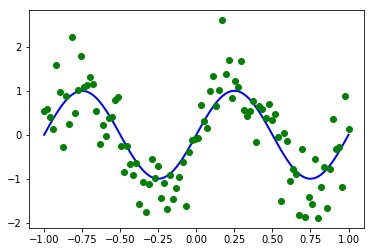

In [4]:
y_test = true_mean_function( x_test )
t_test = add_noise( y_test, sigma )
pp.plot( x_test, y_test, 'b-', lw=2)
pp.plot( x_test, t_test, 'go')

### 1. Sampling from the Gaussian process prior (30 points)

We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 k_n_m( xn, xm, thetas ) (10 points)
To start, implement function "k_n_m( xn, xm, thetas )" that takes scalars $\xn$ and $\xm$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points). 

<img src="figures/kernel_func.png">

In [5]:
def k_n_m(xn, xm, thetas):

    assert len(thetas) == 4, "theta should contain four values"
    res = thetas[0] * np.exp(-(thetas[1]/2)*(np.absolute(xn - xm)**2)) + thetas[2] + (thetas[3] * (np.dot(xn, xm)))
    return res

#### 1.2 computeK( X1, X2, thetas ) (5 points)
Eqn 6.60 is the marginal distribution of mean ouput of $N$ data vectors: $p(\y) = \mathcal{N}(\zero, \K)$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N$ by $N$ kernel matrix $\K$.  Write a function "computeK( X1, X2, thetas )" that computes the kernel matrix. Hint: use k_n_m as part of an innner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary) (5 points).  

In [6]:
def computeK(X1, X2, thetas):

    N = np.size(X1)
    M = np.size(X2)
    K = np.zeros((N, M))

    for x1 in range(N):
        for x2 in range(M):
            K[x1, x2] = k_n_m(X1[x1], X2[x2], thetas)

    return K

#### 1.3 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\yi \sim \mathcal{N}(\zero, \K_{\thetav})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\y$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\K$ (the diagonal of $\K$ is the variance of the model uncertainty) (15 points).

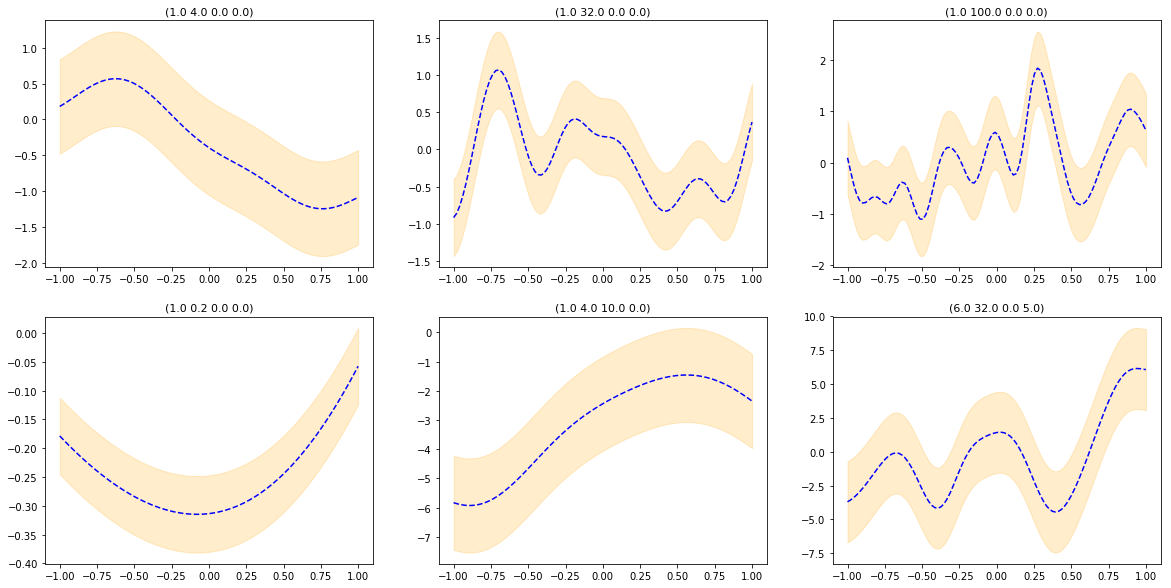

In [7]:
def plotpriorY(theta, x_test, mu):

    figTitle = "(" + " ".join(["%.1f" % (f) for f in theta]) + ")"
    K = computeK(x_test, x_test,  theta)
    Y = np.random.multivariate_normal(mu, K)
    yStd = np.std(Y)
    Y_plus = Y + yStd
    Y_min = Y - yStd
    pp.title(figTitle, fontsize=11)
    pp.plot(x_test, Y, "b--")
    pp.fill_between(x_test, Y_plus, Y_min, color='orange', alpha='0.2')
    
    
thetas = [[1.0, 4.0, 0.0, 0.0],
                  [1.0, 32.0, 0, 0],
                  [1.0, 100.0, 0, 0],
                  [1.0, 0.25, 0, 0],
                  [1.0, 4.0, 10.0, 0],
                  [6.0, 32.0, 0, 5.0]]


pp.close('all')
pp.figure(figsize=(20,10))
for idx in range(len(thetas)):
    pp.subplot(2, 3, idx+1)
    plotpriorY(thetas[idx], x_test, mu_test)
# pp.tight_layout()
pp.show()

### 2. Predictive distribution (35 points)

So far we have sampled mean functions from the prior.  We can draw actual data $\t$ two ways.  The first way is generatively, by first sampling $\y | \K$, then sampling $\t | \y, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\y$ (the mean draw) and directly sample $\t | \K, \beta$ using Eqn 6.61.    This is the generative process for $\t$.  Note that we have not specified a distribution over inputs $\x$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\x$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $\CN$, $\k$, and $c$.  The covariance matrix $CN$ for $\tN$ is $\CN = \KN + \eyeN / \beta$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\k$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function "gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C = None)" that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data.  By having C as an optional parameter, we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\C$, $\k$, and $c$ and the mean and noise functions.  Do not forget: the computeK function computes $\K$, not $\C$! (10 points)

<img src="figures/bishop_666.png">

In [18]:
def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None):

    """ compute C, k and c and the mean and noise functions
         x_test = the test points (x-values) that we're going to predict, based on the predictive distribution
         that we compute (mean/covariance) based on the training data (x_train, t_train) that we already
         observed (e.g. we observed 2 points and now we predict (again) 100 test points)
         x_train = the new train data for prediction
         t_train = the target values for the train data
    """
    N = np.size(x_train)
    M = np.size(x_test)
    K = computeK(x_train, x_train, theta)
    k = computeK(x_test, x_train, theta)
    
    c = computeK(x_test, x_test, theta) + 1/beta

    # only compute C if not given
    if C is None:
        C = K + np.eye(N)/beta 
    # print C.shape
    invC = np.linalg.inv(C)
    # this is the beta used in Bishop Eqn. 6.66
    # mean_plus = np.dot(k, np.dot(invC, t_train))
    # print("Shape of k, invC and t_train", k.shape, invC.shape, t_train.shape)
    mean_plus = np.dot(np.dot(k, invC), t_train)
    # this is the beta used in Bishop Eqn. 6.67
    sigma_plus = c - np.dot(k, np.dot(invC, k.T))

    return C, invC, mean_plus, sigma_plus, k, c



#### 2.2 gp_log_likelihood(...) (10 points)
Later, to learn the hyperparameters, we will need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\thetav$.  Write a function "gp_log_likelihood( x_train, t_train, theta, C = None, invC = None )", where C and invC can be stored and reused.  (10 points)

In [9]:
def gp_log_likelihood(x_train, t_train, theta, C=None, invC=None):

    N = np.size(x_train)
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + (np.linalg.inv(beta * np.eye(N)))

    if invC is None:
        invC = np.linalg.inv(C)

    logL = -0.5*(np.log(np.linalg.det(C))) - 0.5*(np.dot(t_train, np.dot(t_train, invC))) - 0.5*(N*np.log(2*np.pi))
    # print "Log likelihood %s" % (logL)
    return logL

#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the sinuosoidal data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. (10 points)  Try to understand the two types of uncertainty!  If you do not use "gp_plot", please add a fill between for the model and target noise. 

In [10]:
def gp_plot_org( x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta ):
    # x_test:   the test data
    # y_test:   the true function at x_test
    # mu_test:  predictive mean at x_test
    # var_test: predictive covariance at x_test 
    # t_train:  the training values
    # theta:    the kernel parameters
    # beta:     the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(np.diag(var_test))         # includes all uncertainty, model and target noise 
    std_model = np.sqrt( std_total**2 - 1.0/beta ) # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt( 1.0/beta )    # add stddev (note: not the same as full)
    
    pp.plot( x_test, y_test, 'b', lw=3)
    pp.plot( x_test, mu_test, 'k--', lw=2 )
    pp.fill_between( x_test, mu_test+2*std_combo,mu_test-2*std_combo, color='k', alpha=0.25 )
    pp.fill_between( x_test, mu_test+2*std_model,mu_test-2*std_model, color='r', alpha=0.25 )
    pp.plot( x_train, t_train, 'ro', ms=10 )
    


('Shape of k, invC and t_train', (100, 5), (5, 5), (5,))
('Shape of k, invC and t_train', (100, 5), (5, 5), (5,))
('Shape of k, invC and t_train', (100, 5), (5, 5), (5,))
('Shape of k, invC and t_train', (100, 5), (5, 5), (5,))
('Shape of k, invC and t_train', (100, 5), (5, 5), (5,))
('Shape of k, invC and t_train', (100, 5), (5, 5), (5,))


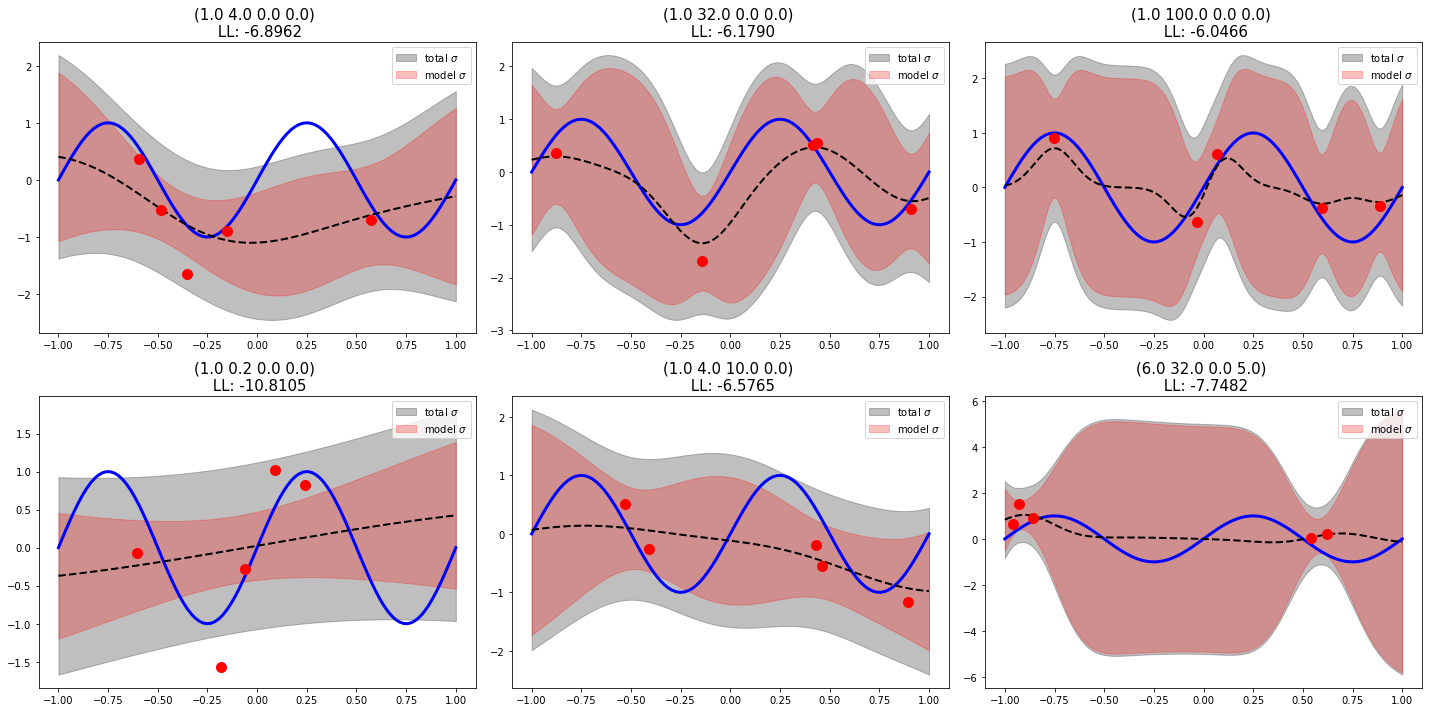

In [28]:
def gp_plot(ax, x_test, y_test, mu_test, var_test, x_train, t_train, theta, beta, logL):
    # x_test:   the test data
    # y_test:   the true function at x_test
    # mu_test:  predictive mean at x_test
    # var_test: predictive covariance at x_test
    # t_train:  the training values
    # theta:    the kernel parameters
    # beta:     the precision (known)

    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(np.diag(var_test))         # includes all uncertainty, model and target noise
    std_model = np.sqrt(std_total**2 - 1.0/beta)  # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt(1.0/beta)    # add stddev (note: not the same as full)

    figTitle = "(" + " ".join(["%.1f" % (f) for f in theta]) + ") \n LL: %.4f" % (logL)
    ax.set_title(figTitle, fontsize=15)
    # y_min, y_max = np.min(mu_test - 2*std_total), np.max(mu_test + 2*std_total)
    # print(y_min, y_max)
    # y_min -= y_min * 0.15
    # y_max += y_max * 0.1
    ax.plot(x_test, y_test, 'b', lw=3)
    # ax.set_ylim([y_min, y_max])
    ax.plot(x_test, mu_test, 'k--', lw=2)
    ax.fill_between(x_test, mu_test + 2*std_total, mu_test - 2*std_total, color='k', alpha=0.25,
                    label=r'total $\sigma$')
    ax.fill_between(x_test, mu_test + 2*std_model, mu_test - 2*std_model, color='r', alpha=0.25,
                    label=r"model $\sigma$")
    ax.plot(x_train, t_train, 'ro', ms=10)
    ax.legend(loc="best")

    
def generateTrainPoints(numOfTrainPoints):

    x_train_new = np.random.uniform(-1, 1, size=numOfTrainPoints)
    t_train_new = generate_t(x_train_new, sigma)

    return x_train_new, t_train_new
    
def generatePlot_condTrainPoints(ax, x_test, y_test, theta, beta, numOfTrainPoint):
    """
        y_test: true mean function
    """
    x_train, t_train = generateTrainPoints(numOfTrainPoint)
    C, invC, mean_plus, sigma_plus, k, c = gp_predictive_distribution(x_train, t_train, x_test, theta, beta, None)
    # print C.shape, mean_plus.shape, sigma_plus.shape
    # construct_joint_cov(K, k, c)
    logL = gp_log_likelihood(x_train, t_train, theta)
    gp_plot(ax, x_test, y_test, mean_plus, sigma_plus, x_train, t_train, theta, beta, logL)

x_test = np.linspace(-1,1,N_test)
y_test = true_mean_function( x_test )

counter = 230
pp.close('all')
pp.figure(figsize=(20,10))
for theta in thetas:
    counter += 1
    ax = pp.subplot(counter)
    generatePlot_condTrainPoints(ax, x_test, y_test, theta, beta, 5)
pp.tight_layout()
pp.show()
    

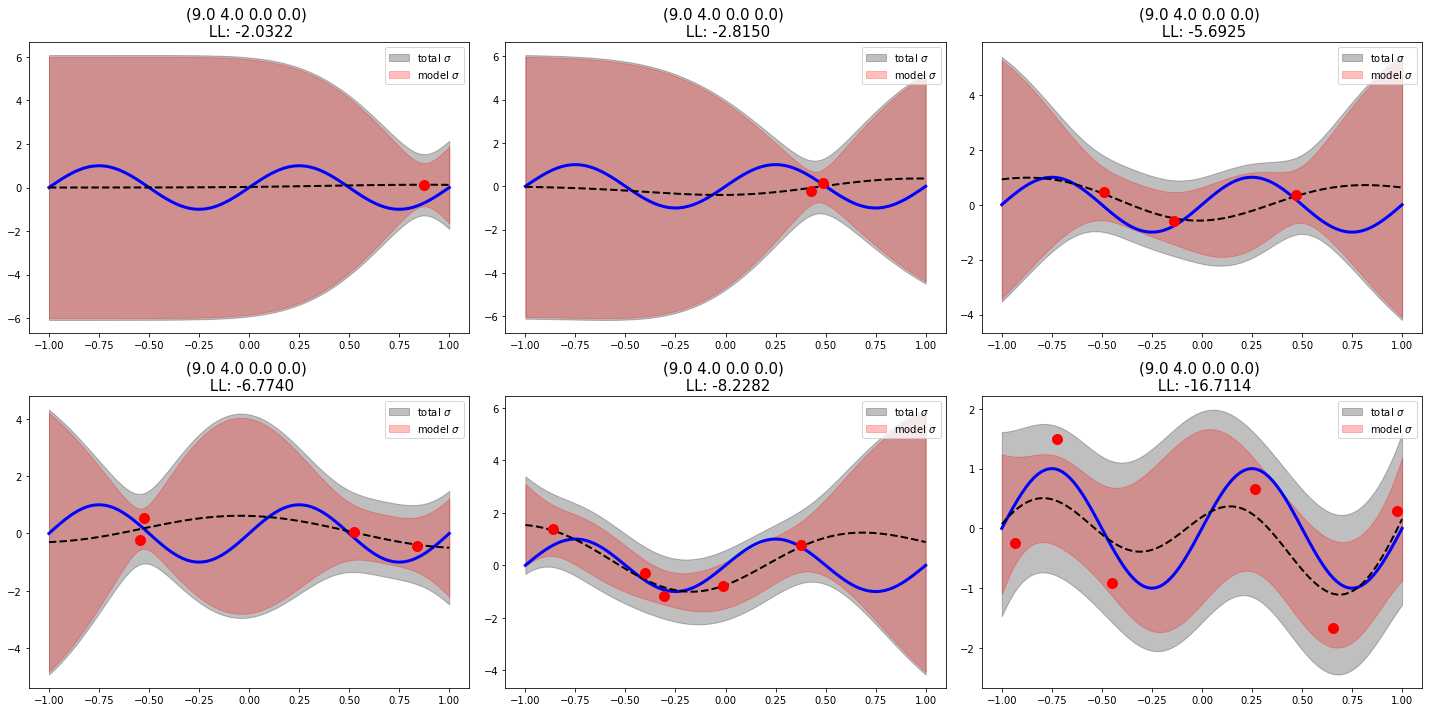

In [18]:
counter = 230
pp.close('all')
pp.figure(figsize=(20,10))
num_of_test_points = 6
for t_point in np.arange(num_of_test_points):
    counter += 1
    ax = pp.subplot(counter)
    generatePlot_condTrainPoints(ax, x_test, y_test, thetas[1], beta, t_point+1)
pp.tight_layout()
pp.show()

#### 2.4 More ploting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

6


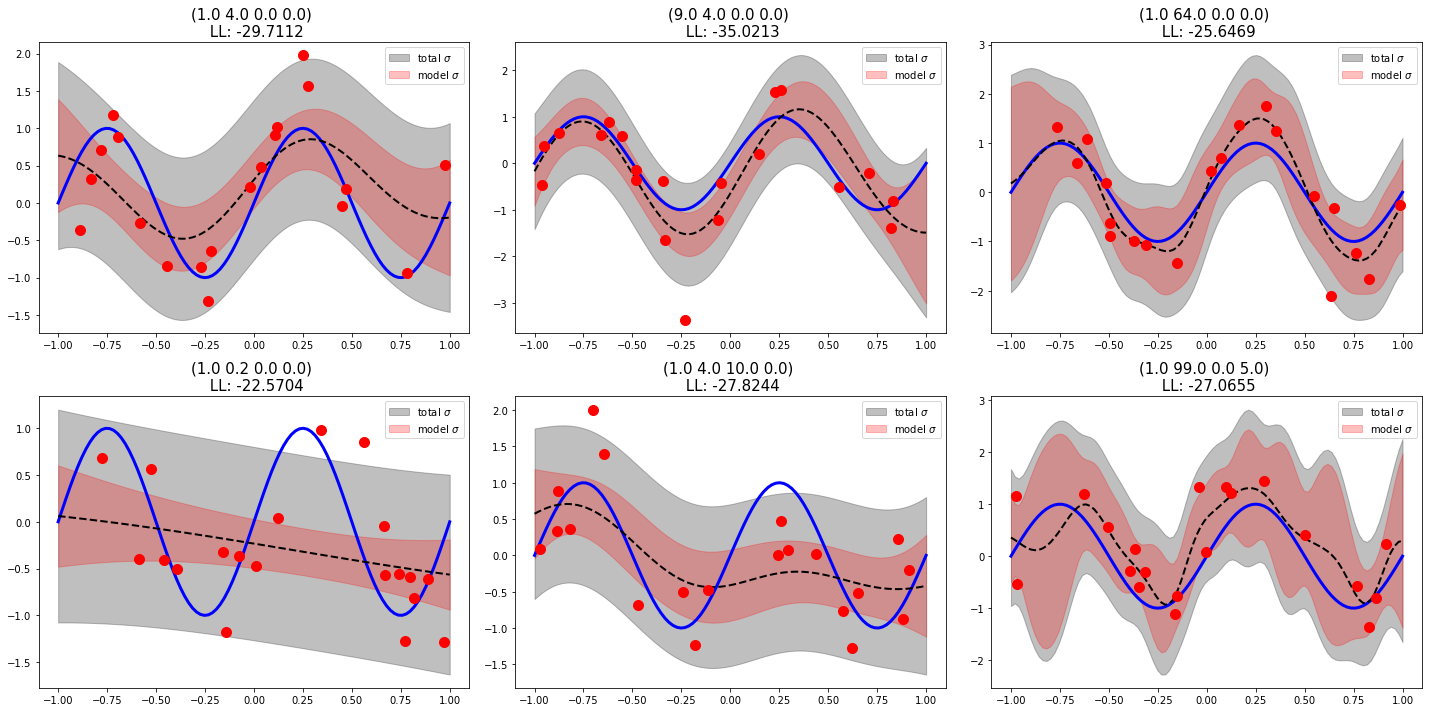

In [24]:
x_test = np.linspace(-1,1,N_test)
y_test = true_mean_function( x_test )
counter = 230
pp.close('all')
pp.figure(figsize=(20,10))
print len(thetas)
for idx in range(len(thetas)):
    counter += 1
    ax = pp.subplot(counter)
    generatePlot_condTrainPoints(ax, x_test, y_test, thetas[idx], beta, 20)
pp.tight_layout()
pp.show()



### 3. Learning the hyperparameters (45 points)

Learning the values of the parameter $\thetav$ can be very tricky for Gaussian processes in general, but when the data is univariate like ours, we can visualize the fit and see how plausible it looks.

#### 3.1 Derivatives (5 points)
Maximum likelihood or MAP learning is the most common way of setting the parameters, though a fully Bayesian approach is possible too.  We will look at ML today.  For this, we start with the dervivative of the log-likelihood with respect to the parameters $\thetav$; this is Eqn 6.70.  This, in turn, requires the derivative of the kernel matrix $\CN$ wrt $\thetav$.  This is the matrix of element-wise derivatives of the kernel function.  Write the derivatives for $\theta_0$ to $\theta_3$ for our kernel function (5 points).  

$$
C_N = k(x_n, x_m) + \beta^{-1} \delta_{nm} \\
k(x_n, x_m) = \theta_0 \exp \Big\{ - \frac{\theta_1}{2} \| x_n - x_m \|^2 \Big\} + \theta_2 + \theta_3 x_n^Tx_m 
$$
$$
\frac{\partial }{\partial \theta_0} k(x_n, x_m) = \exp \Big\{ - \frac{\theta_1}{2} \| x_n - x_m \|^2 \Big\} \\
\frac{\partial }{\partial \theta_1} k(x_n, x_m) = \theta_0 \exp \Big\{ - \frac{\theta_1}{2} \| x_n - x_m \|^2 \Big\} \Big(- \frac{1}{2} \| x_n - x_m \|^2 \Big) = -\frac{\theta_0}{2} \| x_n - x_m \|^2 \exp \Big\{ - \frac{\theta_1}{2} \| x_n - x_m \|^2 \Big\} \\
\frac{\partial }{\partial \theta_2} k(x_n, x_m) = 1 \\
\frac{\partial }{\partial \theta_3} k(x_n, x_m) = x_n^Tx_m 
$$

#### 3.2 Questions (5 points)
Which parameters in $\thetav$ are unconstrained, that is, where any positive/ negative values are valid? (5 points)

$\theta_0$ and $\theta_1$ must be greater than zero and are therefore constrained (they can be interpreted as $\textit{length-scale}$ and $\textit{signal variance}$). Whereas the parameters $\theta_2$ and $\theta_3$ are unconstrained.

#### 3.3 More derivatives (5 points)
For parameters that are constrained to be positive, the usual approach is to use the exponential of the free-parameter in the kernel function, but perform gradient ascent on the unconstrained values.  Consider the case  $\theta_i = \exp( \phi_i)$, where $\phi_i$ is unconstrained.  Write the derivative for $\phi_i$ in terms of the derivatives you already computed (5 points).  Hint: use the chain rule and do not repeat the full derivation.


[___answer here___]

#### 3.4 Grid search (10 points)
Grid-search: for the same training set you have above, perform a small grid search over $\thetav$ (try at least 20 combinations).  Have your grid-search loop or function print out rows of log-likelihood + $\thetav$ sorted by best to worst.  Use the log-likelihood to select the best $\thetav$ and the worst.  Plots both the same way as the subplots above (ie a 1 by 2 subplot of best and worst). (10 points)

Worst model parms: (5.0, 70.0, 12.0, 16.0), LL: -12.3309
Best model parms: (1.0, 50.0, 4.0, 8.0), LL: -9.8566


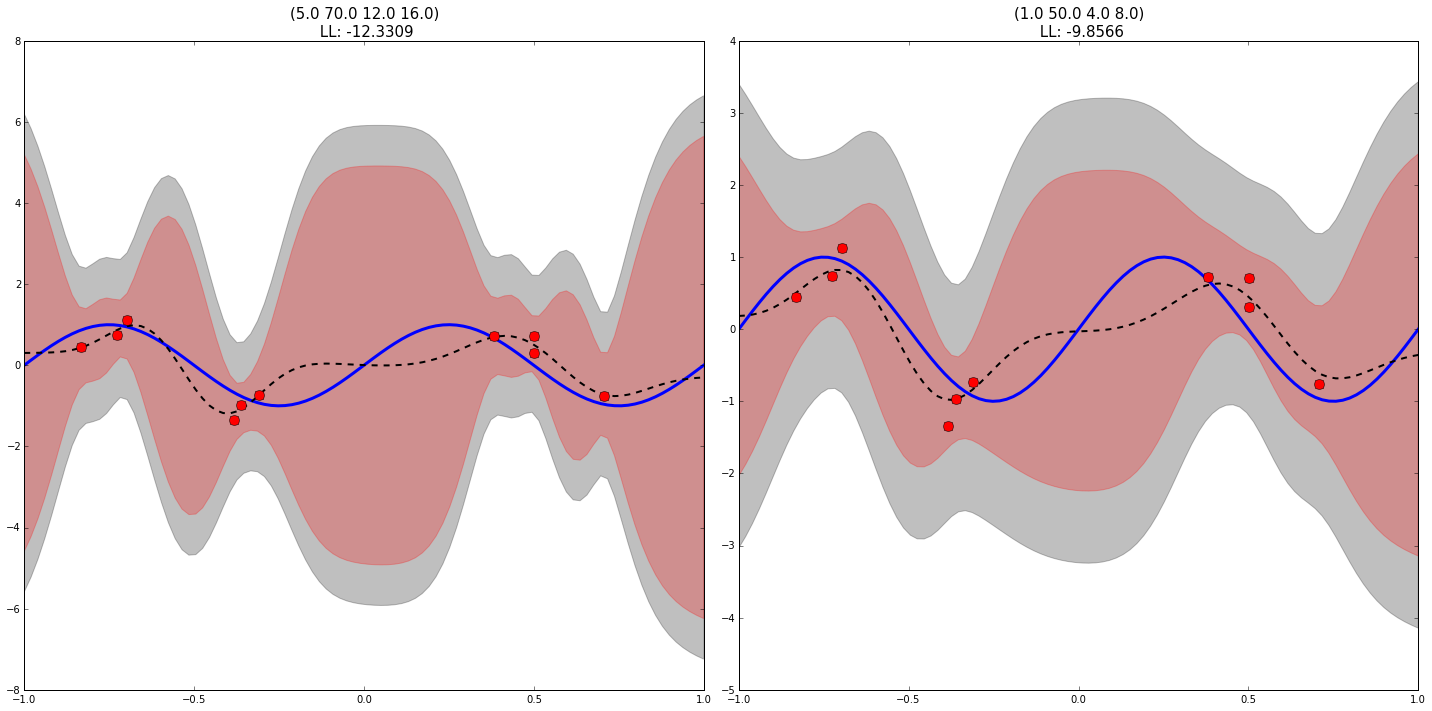

In [140]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = np.floor(np.linspace(0,N,k+1))
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds

def generateSets(x,t):
    validSetVectors = []
    trainSetVectors = []
    validTVectors = []
    trainTVectors = []
    
    for idx in valid_folds:
        validSetVectors.append(x[idx])
        validTVectors.append(t[idx])
    for idx in train_folds:
        trainSetVectors.append(x[idx])
        trainTVectors.append(t[idx])
        
    return trainSetVectors, trainTVectors, validSetVectors, validTVectors


def gp_log_likelihood_LOO(mu, var, t):
    
    #print "t = %s, mu = %s, var = %s" % (t, mu, var)
    logL = -0.5*np.log(var) - 0.5*((t-mu)**2/var) - 0.5*np.log(2**pi)
    return logL

def testModel(model_parms, trainSet, trainTset, validateSet, valTset):
    
    
    C, invC, mean_plus, var_plus, k, c = gp_predictive_distribution(trainSet, trainTset, validateSet, model_parms, beta, None)
    logL = gp_log_likelihood_LOO(mean_plus[0], var_plus[0,0], valTset[0])
    return logL

def plotModels(x_train, t_train, x_test, y_test, thetas, LLs):
    
    counter = 120
    pp.close('all')
    pp.figure(figsize=(20,10))
    for idx in range(len(thetas)):
        counter += 1
        ax = pp.subplot(counter)
        C, invC, mean_plus, var_plus, k, c = gp_predictive_distribution(x_train, t_train, x_test, thetas[idx], beta, None)
        gp_plot(ax, x_test, y_test, mean_plus, var_plus, x_train, t_train, thetas[idx], beta, LLs[idx])
    pp.tight_layout()
    pp.show()
    

x_test = np.linspace(-1,1,N_test)
y_test = true_mean_function( x_test )
""" construct k-fold cross validation sets
    using leave-one-out system
"""
N = 10
k = 10
x_train, t_train = generateTrainPoints(N)
train_folds, valid_folds = kfold_indices(N, k)
trainSet, trainTset, validateSet, valTset = generateSets(x_train, t_train)

""" use reasonable intervals in order to test hyperparameters
    theta_0 to theta_3
"""
thetas_0 = np.linspace(1,5,4)
thetas_1 = np.linspace(50,70,4)
thetas_2 = np.linspace(4,12,4)
thetas_3 = np.linspace(8,16,4)

log_results = []
all_parms = []

for th_0 in thetas_0:
    for th_1 in thetas_1:
        for th_2 in thetas_2:
            for th_3 in thetas_3:
                model_parms = (th_0, th_1, th_2, th_3)
                logL = 0.0
                for idx in range(N):
                    logL = logL + testModel(model_parms, trainSet[idx], trainTset[idx], validateSet[idx], valTset[idx])
                log_results.append(logL)
                all_parms.append(model_parms)

idx_best = log_results.index(max(log_results))
idx_worst = log_results.index(min(log_results))
print "Worst model parms: %s, LL: %.4f" % (all_parms[idx_worst], log_results[idx_worst])
print "Best model parms: %s, LL: %.4f" % (all_parms[idx_best], log_results[idx_best])

plotModels(x_train, t_train, x_test, y_test, [list(all_parms[idx_worst]), list(all_parms[idx_best])], 
           [log_results[idx_worst], log_results[idx_best]])



                


[___answer here___]

#### 3.5 Questions (10 points)
Selecting kernel functions can be somewhat of an art.  There are charateristics of kernel functions that are useful for some data sets, but not others.  Complicating the matter is the ability to combine kernels with different characteristics (long term trends + seasonal fluctuations).  Describe the charactistics of the kernel function we are using in terms of (signal, scale, offsets, etc). You may want to play around with $\thetav$ and see what each parameter does/affects/etc.  (5 points)  Describe why the best parameters work well for the training data and explain why the bad parameter settings perform poorly (in terms of the first part of the question).  (5 points)

[___answer here___]

#### 3.6 Bonus: Implementation (20 points)
Implement gradient-ascent (or descent if you wish) using the combination of a) the log-likelihood objective function and b) the gradients you calculated above.  Run on the training data above and show the log-likehood curve as it learns and a plot of the final model.  Feel free to use available software (eg search for "minimize.py" which uses conjugate gradient descent, or something in scipy).  NB: log-likelihood should be monotonically increasing.  You are encouraged to also search and use "checkgrad".  (20 points)